1. Import libraries

In [1]:
import tensorflow as tf
import os,re
import pandas as pd
import numpy as np
from tensorflow.keras import layers,models
from tensorflow.keras import losses,metrics,optimizers
import matplotlib.pyplot as plt
from functools import partial

2024-04-23 15:59:34.443564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 15:59:34.443671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 15:59:34.597712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus=tf.config.list_physical_devices('GPU')

#configure the GPU(s), to use the memory necessary up to the GPU max memory
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
            print(tf.config.experimental.get_device_details(gpu))
        logi_gpu=tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus),'Physical GPU(s)',len(logi_gpu),'Logical GPU(s)')
        
    except RuntimeError as e:
        print(e)
print("Is gpu available?, :",tf.test.is_gpu_available(cuda_only=False,min_cuda_compute_capability=None))

Num GPUs Available:  1
{'compute_capability': (6, 0), 'device_name': 'Tesla P100-PCIE-16GB'}
1 Physical GPU(s) 1 Logical GPU(s)
Is gpu available?, : True


2. Create dataset
    - Get paths
    - Read files
    - Decode images and labels

In [3]:
#Get paths
path="/kaggle/input/tpu-getting-started"
train_path=[]
test_path=[]
val_path=[]
dir_paths=os.listdir(path)
for folder in dir_paths:
    #get the path to the files in the various folders contain by the dataset
    dir=os.path.join(path,folder)
    if os.path.isdir(dir):
        test_path.extend([os.path.join(dir,"test",i) 
                        for i in os.listdir(os.path.join(dir,"test"))])
        val_path.extend([os.path.join(dir,"val",i) 
                        for i in os.listdir(os.path.join(dir,"val"))])
        train_path.extend([os.path.join(dir,"train",i) 
                        for i in os.listdir(os.path.join(dir,"train"))])
print("Train paths lenght:",len(train_path))
print("Validation paths lenght:",len(val_path))
print("Train paths lenght:",len(test_path))


Train paths lenght: 64
Validation paths lenght: 64
Train paths lenght: 64


In [4]:
#Read files and decode images and label
TV_FEATURE_DES={"image":tf.io.FixedLenFeature([],tf.string),
                    "class":tf.io.FixedLenFeature([],tf.int64)}
T_FEATURE_DES={"image":tf.io.FixedLenFeature([],tf.string),
               "id":tf.io.FixedLenFeature([],tf.string)}
IMG_SIZE=[200,200]

In [5]:
#@tf.function
def _parse_function(img_exp,img_size,feature_des,c="class"):
    FEATURE_DES=feature_des
    IMG_SIZE=img_size
    exp=tf.io.parse_single_example(img_exp,FEATURE_DES)
    img=tf.image.decode_image(exp["image"],channels=3,expand_animations=False)
    img=tf.cast(img,tf.float32)/255.0
    img=tf.image.resize(img,IMG_SIZE)
    img=tf.clip_by_value(img,0.0,1.0)
    label=exp[c]
    if c!="id":
        label=tf.cast(label,tf.int32)
        label=tf.one_hot(label,on_value=1,off_value=0,depth=104)
    return img,label

def _data_augmentation(img,label):
    img=tf.image.random_brightness(img,0.2)
    img=tf.image.random_flip_left_right(img)
    img=tf.image.random_crop(img,size=[192,192,3])
    img=tf.image.random_flip_up_down(img)
    img=tf.image.resize(img,size=IMG_SIZE)
    img=tf.clip_by_value(img,0.0,1.0)
    return img,label
#@tf.function
def load_train_dataset():
    #print("load_dataset")
    dataset=tf.data.TFRecordDataset(train_path)
    partial_parse_function=partial(_parse_function,img_size=IMG_SIZE,
                                   feature_des=TV_FEATURE_DES,c="class")
    
    dataset=dataset.map(partial_parse_function)#decode the images and labels
    #dataset=dataset.map(_data_augmentation)#data augmentation
    dataset=dataset.repeat()
    dataset=dataset.shuffle(buffer_size=1000)
    dataset=dataset.batch(30)
    
    return dataset

def load_val_dataset():
    dataset=tf.data.TFRecordDataset(val_path)
    partial_parse_function=partial(_parse_function,img_size=IMG_SIZE,
                                   feature_des=TV_FEATURE_DES,c="class")
    
    dataset=dataset.map(partial_parse_function)#decode the images and labels
    #dataset=dataset.repeat()
    dataset=dataset.shuffle(buffer_size=1000)
    dataset=dataset.batch(1)
    return dataset
    
def load_test_dataset():
    dataset=tf.data.TFRecordDataset(test_path)
    #dataset=dataset.with_options(True)
    partial_parse_function=partial(_parse_function,img_size=IMG_SIZE,
                                   feature_des=T_FEATURE_DES,c="id")
    
    dataset=dataset.map(partial_parse_function)#decode the images and labels
    dataset=dataset.batch(1)
    return dataset


In [6]:
train_dataset=load_train_dataset()
val_dataset=load_val_dataset()
test_dataset=load_test_dataset()

3. explore some training data
    - def functions
    - plot images

<Figure size 8000x8000 with 0 Axes>

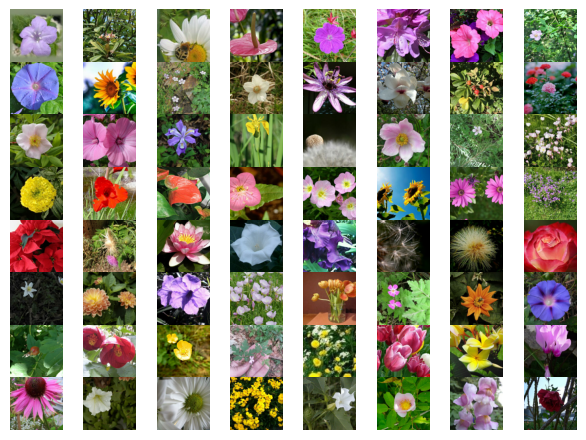

In [7]:
#def functions and plot some images
def explore_images(data,n,cols,rows):
    x=10
    if n!=int(rows*cols):
        raise "n has to be the same as cols*rows"
    plt.figure(figsize=(int(x*rows),int(x*cols)))
    plt.subplots(rows,cols)
    plt.tight_layout()
    cont=1
    for i,l in data.take(n):
        plt.subplot(rows,cols,cont)
        plt.imshow(tf.reshape(i,[*IMG_SIZE,3]))
        plt.axis("off")
        cont+=1
    plt.subplots_adjust(wspace=0,hspace=0)
    plt.show()

explore_images(train_dataset.unbatch(),64,8,8)
    

4. define model
    - define model
    - define model's metrics, loss and optimizer
    - train model
    - plot training curves

In [17]:
#define model
conv_base=tf.keras.applications.EfficientNetB0(include_top=True,input_shape=[*IMG_SIZE,3],weights=None,
                                     classes=104)
#Define model
#freeze up to


conv_base.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 200, 200,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 200, 200,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 201, 201,  │          0 │ normalization_1[… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 100, 100,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 100, 100,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 100, 100,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 100, 100,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 100, 100,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 100, 100,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 100, 100,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 100, 100,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 100, 100,  │         64 │ block1a_project_

 Total params: 4,182,795 (15.96 MB)

 Trainable params: 4,140,772 (15.80 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [18]:
#Define model
model=models.Sequential()
model.add(conv_base)
#model.add(layers.Dropout(0.3))
#model.add(layers.Dense(104,activation="softmax"))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,182,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,182,795 (15.96 MB)

 Trainable params: 4,140,772 (15.80 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [19]:
#define model's metrics, loss and optimizer
model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.CategoricalCrossentropy(),
              metrics=["accuracy"])
print("model's loss function:",model.loss)
print("model's optimizer:",model.optimizer)
print("model's metrics:",model.metrics)

model's loss function: <keras.src.losses.losses.CategoricalCrossentropy object at 0x78d56c4a5f00>
model's optimizer: <keras.src.optimizers.rmsprop.RMSprop object at 0x78d50e1baf50>
model's metrics: [<Mean name=loss>, <CompileMetrics name=compile_metrics>]


In [20]:
#Train model
epochs=100
steps_per_epoch=100
validation_steps=100
history=model.fit(train_dataset,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          validation_data=val_dataset,
          validation_steps=validation_steps
          )

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 169ms/step - accuracy: 0.0586 - loss: 4.8232 - val_accuracy: 0.0100 - val_loss: 4.4431
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.1070 - loss: 3.8705 - val_accuracy: 0.0500 - val_loss: 4.6623
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.1504 - loss: 3.6173 - val_accuracy: 0.0500 - val_loss: 5.4392
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.1483 - loss: 3.4657 - val_accuracy: 0.0200 - val_loss: 4.7514
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.1952 - loss: 3.2681 - val_accuracy: 0.0200 - val_loss: 5.0719
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.2216 - loss: 3.0485 - val_accuracy: 0.0400 - val_loss: 4.9702
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.2341 - loss: 2.9965 - val_accuracy: 0.1800 - val_loss: 3.5355
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.2526 -

In [21]:
model.evaluate(val_dataset.take(5000))

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.5324 - loss: 2.6631


[2.6426358222961426, 0.5379999876022339]

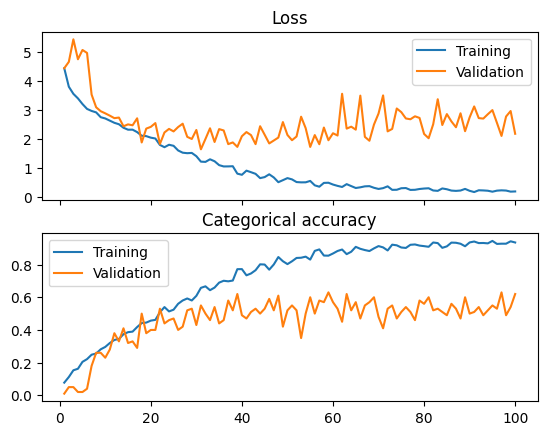

In [22]:
#plot the training 
loss=history.history["loss"]
cat_acc=history.history["accuracy"]
val_loss=history.history["val_loss"]
val_cat_acc=history.history["val_accuracy"]
epochs=range(1,len(loss)+1)
fig,(ax1,ax2)=plt.subplots(2,1,sharex=True)
ax1.plot(epochs,loss,label="Training")
ax1.plot(epochs,val_loss,label="Validation")
ax1.set_title("Loss")
ax1.legend()
ax2.plot(epochs,cat_acc,label="Training")
ax2.plot(epochs,val_cat_acc,label="Validation")
ax2.set_title("Categorical accuracy")
ax2.legend()

In [14]:
df=pd.DataFrame({"id":(),"prediction":()})
t_images=test_dataset.map(lambda images, label:images)
t_id=test_dataset.map(lambda images,label:label)
pre=model.predict(t_images)
pre=np.argmax(pre,axis=1)
id=[]
for i in t_id.unbatch():
    id.append(i.numpy().decode("utf-8")) 
df=pd.DataFrame({"id":id,"label":pre})
df.duplicated("id")

29528/29528 ━━━━━━━━━━━━━━━━━━━━ 162s 5ms/step


0        False
1        False
2        False
3        False
4        False
         ...  
29523     True
29524     True
29525     True
29526     True
29527     True
Length: 29528, dtype: bool

In [15]:
np.count_nonzero(df.duplicated("id"))
print(len(df))
df.drop_duplicates("id",keep="first",inplace=True)
print(len(df))

29528
7382


In [16]:
df=df.drop_duplicates("id",keep="first")
df.to_csv("/kaggle/working/submission.csv",sep=",",index=False)